# User's Guide, Chapter 15: Keys and KeySignatures

Music21 has two main objects for working with keys: the :class:`~music21.key.KeySignature` object, which handles the spelling of key signatures and the :class:`~music21.key.Key` object which does everything a KeySignature object does but also knows more advanced aspects of tonal harmony.  We'll go through the basics of each one here.

We start, like always, by importing music21:

In [1]:
from music21 import *

Now let's get a couple of different key signatures, representing different numbers of sharps:

In [2]:
ks2 = key.KeySignature(2)
ks2.sharps

2

In [3]:
ks7 = key.KeySignature(7)
ks7

<music21.key.KeySignature of 7 sharps>

We can get a list of which pitches (as :class:`~music21.pitch.Pitch` objects) are altered by the key signature with the `.alteredPitches` property:

In [4]:
ks2.alteredPitches

[<music21.pitch.Pitch F#>, <music21.pitch.Pitch C#>]

There's also a method that lets us see what the accidental is for any given step:

In [5]:
ks2.accidentalByStep('C')

<music21.pitch.Accidental sharp>

In [6]:
ks2.accidentalByStep('E') is None

True

Notice that we give a string of just a letter name from C-B.  This won't work:

In [7]:
ks2.accidentalByStep('C#')

We can create key signatures with absurd numbers of sharps and get strange accidentals:

In [8]:
ks12 = key.KeySignature(12)
ks12.accidentalByStep('F')

<music21.pitch.Accidental double-sharp>

These absurd key signatures display in some programs (such as Lilypond) and are exported into MusicXML but do not display in most MusicXML readers.

Key Signatures transpose like Pitches and Notes, taking each of the notes and moving it:

In [9]:
ks4 = ks2.transpose('M2')
ks4

<music21.key.KeySignature of 4 sharps>

And the number of sharps can be changed after the fact:

In [10]:
ks4.sharps = 0
ks4

<music21.key.KeySignature of no sharps or flats>

We can get the Major or Minor scale corresponding to the Key Signature:

In [11]:
ks2.getScale('major')

<music21.scale.MajorScale D major>

In [12]:
ks2.getScale('minor')

<music21.scale.MinorScale B minor>

We'll see what we can do with scales in a bit.

If we put a KeySignature into a Stream, we can see it:

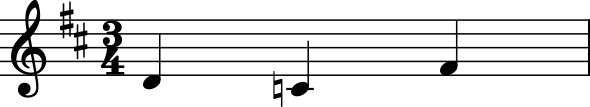

In [13]:
m = stream.Measure()
m.insert(0, meter.TimeSignature('3/4'))
m.insert(0, ks2)
d = note.Note('D')
c = note.Note('C')
fis = note.Note('F#') # German name
m.append([d, c, fis])
m.show()

Note that the Note 'C' is treated as C-natural and thus needs the natural sign in front of it.  The Note F# however does not need a natural sign to be displayed.  The process of calling `.show()` on the stream made a copy of the notes and set the `.pitch.accidental.displayStatus` on the F# to `False` and created an accidental for the C note with a natural and a displayStatus of True. Then the copies were discarded, so we don't see them here:

In [14]:
fis.pitch.accidental.displayStatus

But we could instead call `.makeNotation(inPlace=True)` or `.makeAccidentals(inPlace=True)` on the Measure to do this manually: 

In [15]:
m.makeAccidentals(inPlace=True)
fis.pitch.accidental.displayStatus

False

In [16]:
c.pitch.accidental, c.pitch.accidental.displayStatus

(<music21.pitch.Accidental natural>, True)

If we have a `Measure` (not just any `Stream`) we can also set the KeySignature for the beginning of the measure with the Measure object's `.keySignature` property:

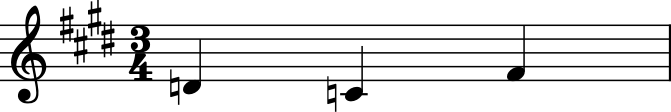

In [17]:
m.keySignature = key.KeySignature(4)
m.show()

Of course life isn't all about sharps; it'd be a pretty terrible KeySignature object if we couldn't have flats.  To do it, just specify the number of flats as a negative number.  So -1 = one flat, -2 = two flats.  Or if you have the number as a positive already, just multiply by -1.

In [18]:
eroicaFlats = 3
ksEroica = key.KeySignature(-1 * eroicaFlats)
ksEroica

<music21.key.KeySignature of 3 flats>

In [19]:
ksEroica.sharps

-3

There is no `.flats` routine:

In [20]:
ksEroica.flats

AttributeError: 'KeySignature' object has no attribute 'flats'

## Example: Adjusting notes to fit the Key Signature

Here's a nice study, suppose you had a score like this:

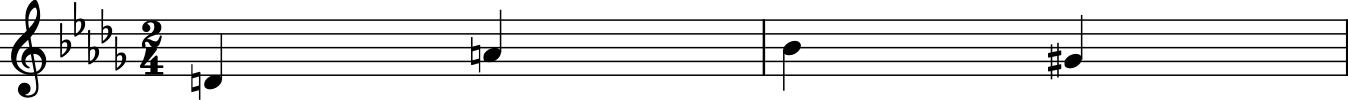

In [21]:
m1 = stream.Measure()
m1.timeSignature = meter.TimeSignature('2/4')
m1.keySignature = key.KeySignature(-5)
m1.append([note.Note('D'), note.Note('A')]) 
m2 = stream.Measure()
m2.append([note.Note('B-'), note.Note('G#')])
p = stream.Part()
p.append([m1, m2])
p.show()

Let's pretend that this was played by a young oboe player who was having trouble with the strange key signature. She got the B-flat right, and remembered to play some accidental on the G, but didn't do very well overall.  Let's fix these notes so that they fit with the key signature.

Now we could simply do something like this for each note:

In [22]:
m1.notes[0].pitch.accidental = pitch.Accidental('flat')

But that wouldn't be as great as getting the notes from the Key itself.  Let's do that with the accidentalByStep routine:

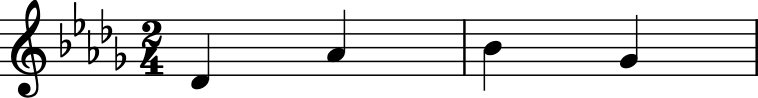

In [23]:
ks = m1.keySignature
for n in p.recurse().notes:  # we need to recurse because the notes are in measures...
    nStep = n.pitch.step
    rightAccidental = ks.accidentalByStep(nStep)
    n.pitch.accidental = rightAccidental
p.show()

Yep, now our student is ready to play the concert!  Though wouldn't this be an easier key?

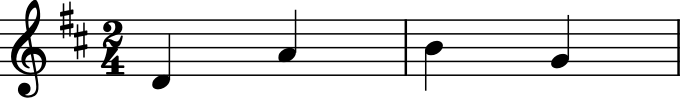

In [24]:
p.transpose(1).show()

## Key objects

A Key is a lot like a KeySignature, but much more powerful.  Unlike a KeySignature, which we initialize with the number of sharps and flats, we initialize a Key with a tonic string or Pitch:

In [25]:
kD = key.Key('D')
kD

<music21.key.Key of D major>

In [26]:
bFlat = pitch.Pitch('B-')
kBflat = key.Key(bFlat)
kBflat

<music21.key.Key of B- major>

By default, keys are major, but we can make minor keys by specifying 'minor' as the second argument:

In [27]:
kd = key.Key('D', 'minor')
kd

<music21.key.Key of d minor>

Note that the key is represented as lowercase ('d minor' as opposed to 'D minor').  This is a clue as to a shortcut for making minor keys:

In [28]:
kg = key.Key('g')
kg

<music21.key.Key of g minor>

We can also take KeySignatures and turn them into Keys by using the `asKey(mode)` method on them:

In [29]:
(ksEroica.asKey('major'), ksEroica.asKey('minor'))

(<music21.key.Key of E- major>, <music21.key.Key of c minor>)

(In the latter case we should probably have called the variable ksFifthSymphony...)

We can also make church modes:

In [30]:
amixy = key.Key('a', 'mixolydian')
amixy

<music21.key.Key of A mixolydian>

If you've forgotten how many sharps or flats are in the key of A mixolydian, you'll be happy to know that all the properties and methods of KeySignatures are also available to Keys:

In [31]:
amixy.sharps

2

In [32]:
amixy.alteredPitches

[<music21.pitch.Pitch F#>, <music21.pitch.Pitch C#>]

In [33]:
amixy.transpose('M3')

<music21.key.Key of C# mixolydian>

In [34]:
aDarkKey = key.Key('B--', 'locrian')
aDarkKey.alteredPitches

[<music21.pitch.Pitch B->,
 <music21.pitch.Pitch E->,
 <music21.pitch.Pitch A->,
 <music21.pitch.Pitch D->,
 <music21.pitch.Pitch G->,
 <music21.pitch.Pitch C->,
 <music21.pitch.Pitch F->,
 <music21.pitch.Pitch B-->,
 <music21.pitch.Pitch E-->,
 <music21.pitch.Pitch A-->,
 <music21.pitch.Pitch D-->,
 <music21.pitch.Pitch G-->,
 <music21.pitch.Pitch C-->,
 <music21.pitch.Pitch F-->]

(as a music historian and someone who specializes in history of music theory, I am contractually obliged to mention that "locrian" is not a historic mode and doesn't really exist in actual music before the 20th c.  But it's fun to play with).

Keys know their `.mode`:

In [35]:
kg.mode, amixy.mode

('minor', 'mixolydian')

They also know their tonic pitches:

In [36]:
kg.tonic, amixy.tonic

(<music21.pitch.Pitch G>, <music21.pitch.Pitch A>)

For major and minor keys, we can get the relative (minor or major) and parallel (minor or major) keys simply:

In [37]:
kg.relative

<music21.key.Key of B- major>

In [38]:
kg.parallel

<music21.key.Key of G major>

And because two keys are equal if their modes and tonics are the same, this is true:

In [39]:
kg.relative.relative == kg

True

This is pretty helpful from time to time:

In [40]:
kg.tonicPitchNameWithCase

'g'

In [41]:
kg.parallel.tonicPitchNameWithCase

'G'

Some analysis routines produce keys:

In [42]:
bach = corpus.parse('bwv66.6')
bach.analyze('key')

<music21.key.Key of f# minor>

The keys from these routines have two extra cool features.  They have a certainty measure:

In [43]:
fis = bach.analyze('key')
fis.correlationCoefficient

0.9379555412471554

In [44]:
fis.tonalCertainty()

1.2642604260880534

Here are some of the other keys that the Bach piece could have been in:

In [45]:
fis.alternateInterpretations[0:4]

[<music21.key.Key of A major>,
 <music21.key.Key of b minor>,
 <music21.key.Key of E major>,
 <music21.key.Key of c# minor>]

And the least likely:

In [46]:
fis.alternateInterpretations[-3:]

[<music21.key.Key of B- major>,
 <music21.key.Key of E- major>,
 <music21.key.Key of c minor>]

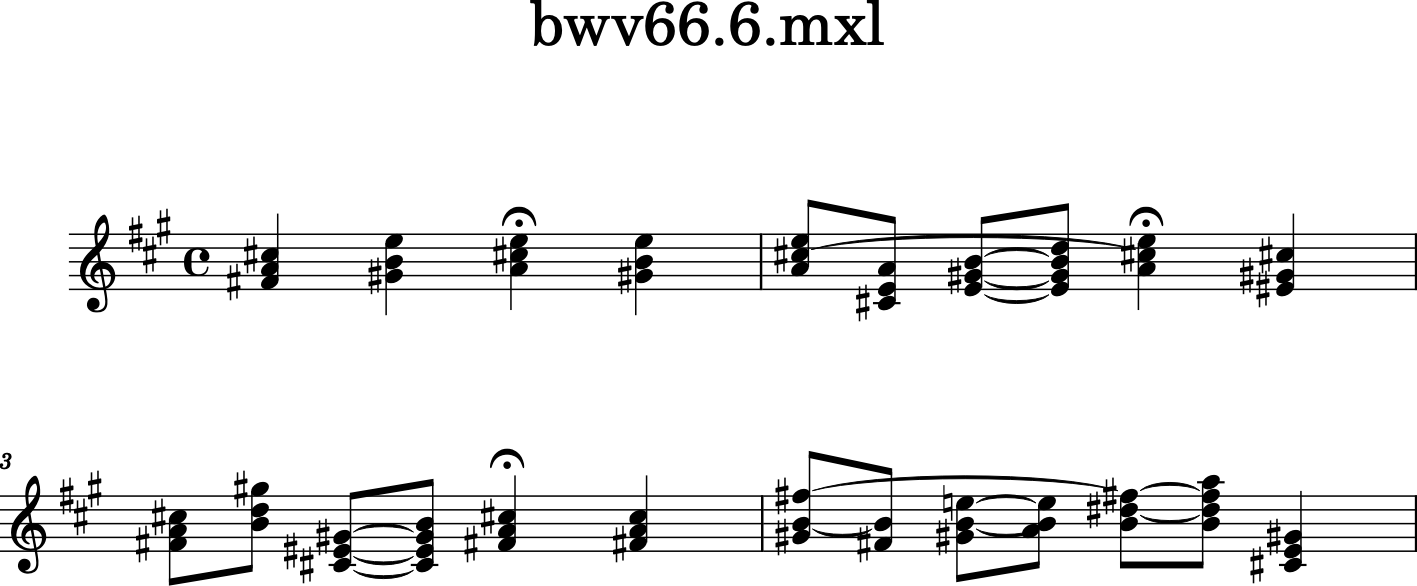

In [47]:
c = bach.measures(1, 4).chordify()
for ch in c.recurse().getElementsByClass('Chord'):
    ch.closedPosition(inPlace=True, forceOctave=4)
c.show()

Yeah, that passes the smell test to me!

So, how does it know what the key is?  The key analysis routines are a variation of the famous (well at least in the small world of computational music theory) algorithm developed by Carol Krumhansl and Mark A. Schmuckler called probe-tone key finding.  The distribution of pitches used in the piece are compared to sample distributions of pitches for major and minor keys and the closest matches are reported.  (see http://rnhart.net/articles/key-finding/ for more details).  `Music21` can be asked to use the sample distributions of several authors, including Krumhansl and Schmuckler's original weights:

In [48]:
bach.analyze('key.krumhanslschmuckler')

<music21.key.Key of f# minor>

Though the `key` returned by `.analyze('key')` and `.analyze('key.krumhanslschmuckler')` are the same, the correlationCoefficient is somewhat different. `fis` is the analysis from `.analyze('key')`.

In [49]:
fisNew = bach.analyze('key.krumhanslschmuckler')
fisCC = round(fis.correlationCoefficient, 3)
fisNewCC = round(fisNew.correlationCoefficient, 3)
(fisCC, fisNewCC)

(0.938, 0.815)

Calling `.analyze()` on a Stream calls :func:`music21.analysis.discrete.analyzeStream` which then calls an appropriate Class there.

There is another way of looking at the key of a piece and that is looking at differently sized windows of analysis on the piece and seeing what happens every quarter note, every half note, every measure, every two measures, etc. to the top.  This plot was created by Jared Sadoian and is explained in the `analysis.windowed` module:

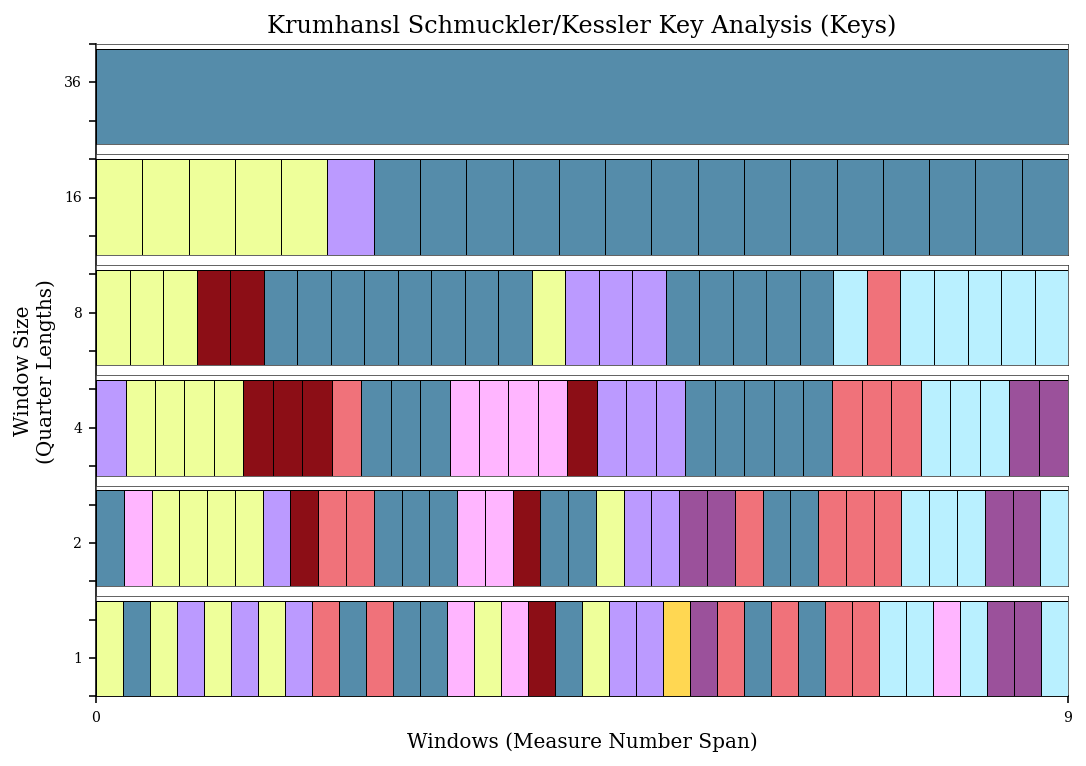

In [50]:
bach.flat.plot('key')

A Key object is derived from a KeySignature object and also a Scale object, which we will explain more about later.

In [51]:
k = key.Key('E-')
k.classes

('Key',
 'KeySignature',
 'DiatonicScale',
 'ConcreteScale',
 'Scale',
 'Music21Object',
 'ProtoM21Object',
 'object')

But for now, a few methods that are present on scales that might end up being useful for Keys as well include:

In [52]:
k.pitchFromDegree(2)

<music21.pitch.Pitch F4>

(octaves in 4 and 5 are chosen just to give some ordering to the pitches)

In [53]:
k.solfeg('G')

'mi'

## Key Context and Note Spelling

`Key` and `KeySignature` objects affect how notes are spelled in some situations.  Let's set up a simple situation of a F-natural whole note in D major and then B-flat minor.

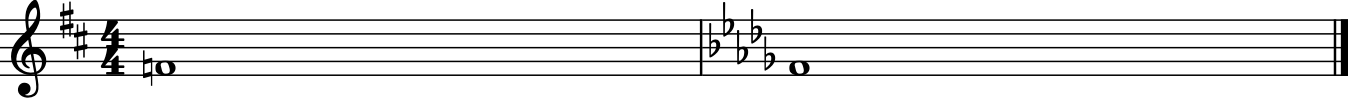

In [54]:
s = stream.Stream()
s.append(key.Key('D'))
s.append(note.Note('F', type='whole'))
s.append(key.Key('b-', 'minor'))
s.append(note.Note('F', type='whole'))
s2 = s.makeNotation()
s2.show()

When we transpose each note up a half step (`n.transpose(1)`), music21 understands that the first F-natural should become F-sharp, while the second one will fit better as a G-flat.

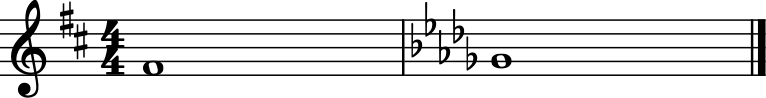

In [55]:
for n in s2.recurse().notes:
    n.transpose(1, inPlace=True)
s2.show()

## Example: Prepare a vocal exercise in all major keys, ascending by step.

Let's create a simple exercise in playing or singing thirds.  I think I remember this from the [First Division Band Method](https://www.google.com/search?q=First+Division+Band+Method&tbm=isch) "Blue Book": 

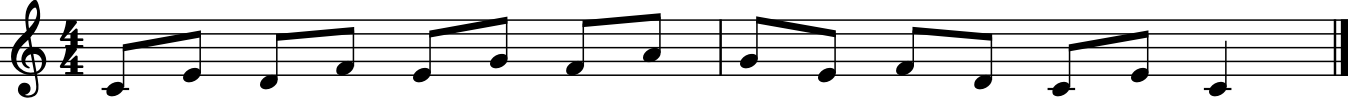

In [56]:
pitchStream = stream.Part()
pitchStream.insert(0, meter.TimeSignature('4/4'))
for step in ('c', 'e', 'd', 'f', 'e', 'g', 'f', 'a',
             'g', 'e', 'f', 'd', 'c', 'e', 'c'):
    n = note.Note(step, type='eighth')
    n.pitch.octave = 4
    pitchStream.append(n)
pitchStream.notes[-1].duration.type = 'quarter'
pitchStream.makeMeasures(inPlace=True)
pitchStream.show()

This melody does not have a key associated with it.  Let's put a Key of C Major at the beginning of the piece:

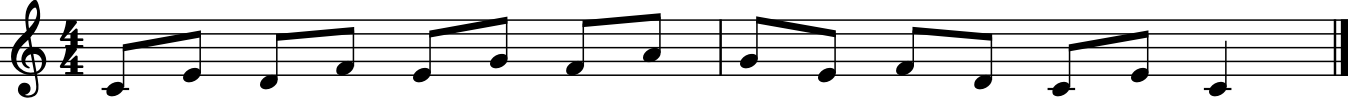

In [57]:
k = key.Key('C')
pitchStream.measure(1).insert(0, k)
pitchStream.show()

Note that putting the key of C into the Stream doesn't change what it looks like when we show the Stream, since there are no sharps or flats.  But what makes the difference between an instrumental and a vocal exercise is the act of transposition. When we transpose the `Key` object up 1 semitone, to D-flat major, it will show up:

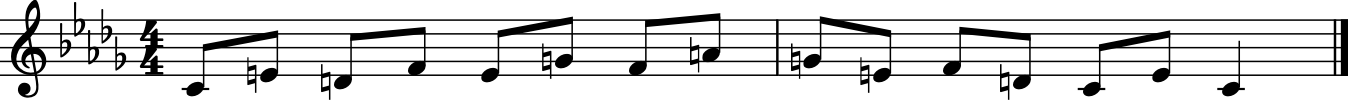

In [58]:
k.transpose(1, inPlace=True)
pitchStream.show()

Now the key signature is D-flat, but the notes are still in C-major, so we should transpose them also:

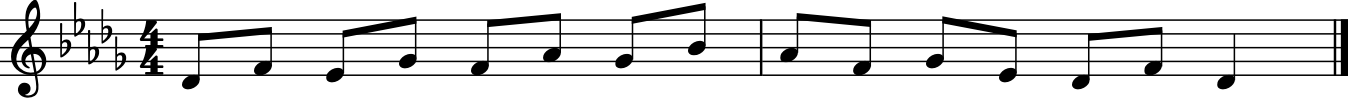

In [59]:
for n in pitchStream.recurse().notes:
    n.transpose(1, inPlace=True)
    
pitchStream.show()

Notice that we choose a semitone transposition and not a diatonic transposition such as minor second (`"m2"`); minor second would work just as good in this case, but then to do another half-step up, we would need to remember to transpose by an augmented unison (`"A1"`) so that D-flat became D-natural and not E-double-flat.  The semitone transposition is smart enough to make sure that the `Key` object remains between six-flats and six-sharps. Not only that, but the notes will match the best spelling for the current key signature.

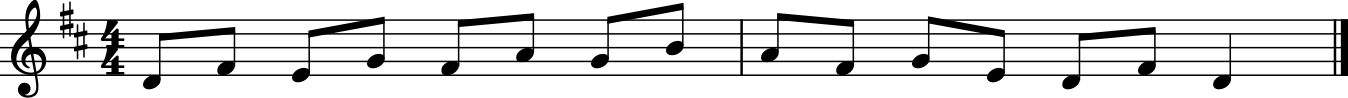

In [60]:
k.transpose(1, inPlace=True)
for n in pitchStream.recurse().notes:
    n.transpose(1, inPlace=True)
pitchStream.show()

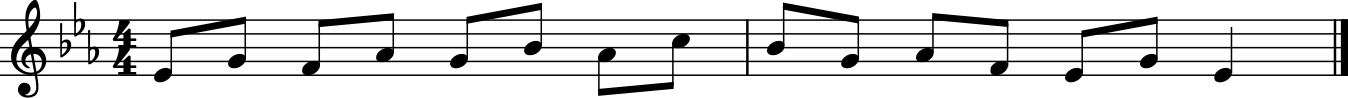

In [61]:
k.transpose(1, inPlace=True)
for n in pitchStream.recurse().notes:
    n.transpose(1, inPlace=True)
pitchStream.show()

So, we can make a nice, ascending vocal exercise by varying the transposition amount from 0 to 7 (or however high you can sing) and putting each of the two-measure excerpts together into one Part.

We will introduce the tinyNotation format here, which will be described in the next chapter:

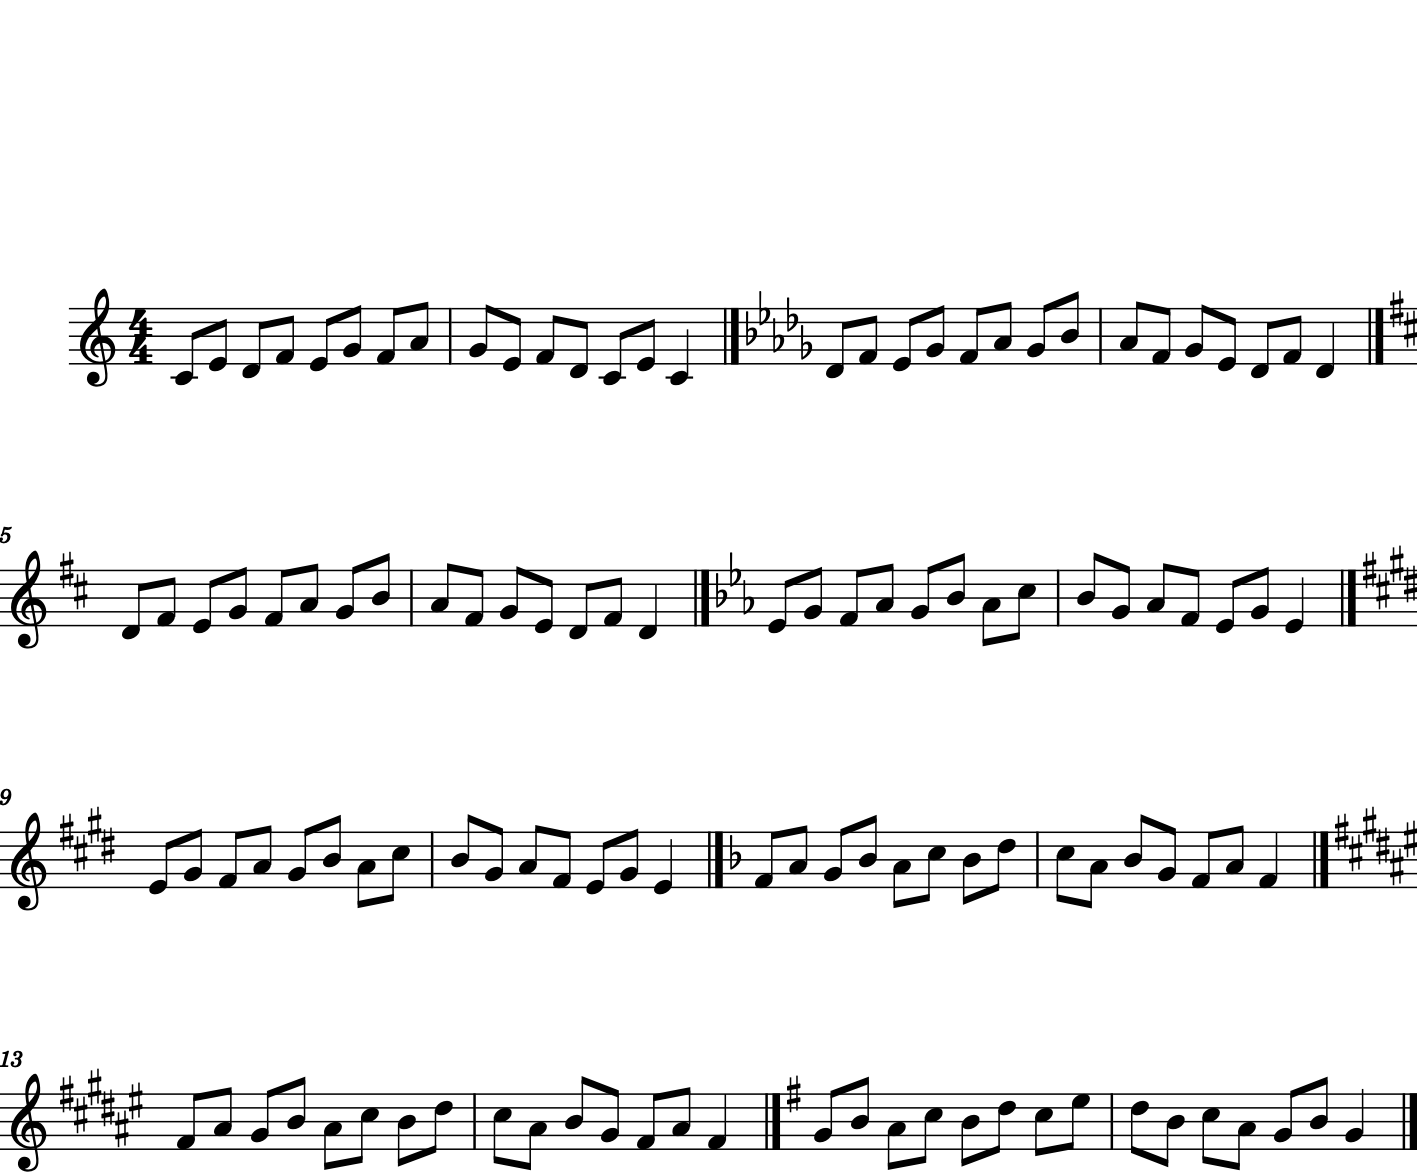

In [62]:
out = stream.Part()
for i in range(0, 8):
    pitchStream = converter.parse("tinyNotation: 4/4 c8 e d f e g f a g e f d c e c4")
    
    if i != 0:
        # remove redundant clefs and time signature
        trebleClef = pitchStream.recurse().getElementsByClass('Clef')[0]
        fourFour = pitchStream.recurse().getElementsByClass('TimeSignature')[0]

        pitchStream.remove(trebleClef, recurse=True)
        pitchStream.remove(fourFour, recurse=True)
        
    if i % 2 == 0:
        # add a line break at the beginning of every other line:
        pitchStream.measure(1).insert(0, layout.SystemLayout(isNew=True))
    
    k = key.Key('C')
    pitchStream.measure(1).insert(0, k)
    k.transpose(i, inPlace=True)
    for n in pitchStream.recurse().notes:
        n.transpose(i, inPlace=True)
    for el in pitchStream:
        out.append(el)

out.show()

And we can listen to it as well:

In [63]:
out.show('midi')

That's enough about keys for now, let's move on to a fast way of getting small amounts of music into music21, with :ref:`Chapter 16, Tiny Notation <usersGuide_16_tinyNotation>`